In [1]:
import sys
sys.path.insert(0, "/work/04233/sw33286/AIDA-SCRIPTS")

In [2]:
import dill
import random
import nltk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.contrib.seq2seq as seq2seq
from tensorflow.contrib.layers import safe_embedding_lookup_sparse as embedding_lookup_unique
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple, GRUCell

from helpers import Indexer
from helpers import batch
# from nltk.corpus import brown
from collections import defaultdict, Counter
from sklearn.cluster import KMeans

### Prepare data

In [232]:
ANIMAL = ['cat','dog','pig','deer','mouse']
VEHICLE = ['car','bike','motorcycle','train','bus']
TYPE2VOCAB = {'animal':ANIMAL, 'vehicle':VEHICLE}
VOCAB = ANIMAL + VEHICLE

indexer = Indexer()
indexer.get_index('PAD')
indexer.get_index('EOS')
for word in VOCAB:
    indexer.get_index(word)

In [233]:
FROM_LEN = 3
TO_LEN = 5

# <== generate clean sentences

# def generate_sent(from_len, to_len, sem_type): 
#     length = np.random.randint(from_len, to_len)
#     return np.random.choice(TYPE2VOCAB[sem_type], length)

# def generate_data(n, from_len=FROM_LEN, to_len=TO_LEN):
#     assert n%2==0 # half for each type.
#     data_X, data_y = [], [] # data_y: for clustering supervision later.
#     for _ in range(n//2):
#         data_X.append(to_code(generate_sent(from_len,to_len,'animal')))
#         data_X.append(to_code(generate_sent(from_len,to_len,'vehicle')))
#         data_y.append(0)
#         data_y.append(1)
#     data_X, data_y = np.array(data_X), np.array(data_y)
#     indices = list(range(n))
#     random.shuffle(indices)
#     return data_X[indices], data_y[indices]

# <== generate vocab-mixed sentences

def generate_sent(from_len, to_len, sem_type1, sem_type2, noise_ratio=0.3): 
    length = np.random.randint(from_len, to_len)
    noise_length = int(np.floor(length*noise_ratio))
    mix = np.concatenate((np.random.choice(TYPE2VOCAB[sem_type2], noise_length),
                          np.random.choice(TYPE2VOCAB[sem_type1], length-noise_length)))
    random.shuffle(mix)
    return mix

def generate_data(n, from_len=FROM_LEN, to_len=TO_LEN):
    assert n%2==0 # half for each type.
    data_X, data_y = [], [] # data_y: for clustering supervision later.
    for _ in range(n//2):
        data_X.append(to_code(generate_sent(from_len,to_len,'animal','vehicle')))
        data_X.append(to_code(generate_sent(from_len,to_len,'vehicle','animal')))
        data_y.append(0)
        data_y.append(1)
    data_X, data_y = np.array(data_X), np.array(data_y)
    indices = list(range(n))
    random.shuffle(indices)
    return data_X[indices], data_y[indices]

def to_code(sent):
    return [indexer.get_index(word) for word in sent]

def to_sent(code):
    return list(map(lambda w_idx:indexer.get_object(w_idx), code))

In [234]:
class DataIterator:
    
    def __init__(self, X, y, shuf=False):
        self.X = X
        self.y = y
        self.cursor = 0
        self.epoch = 0
        self.shuf = shuf
        self.size = len(self.X)
        self.indices = list(range(len(self.X)))
    
    def shuffle(self):
        random.shuffle(self.indices)
        self.X = self.X[self.indices]
        self.y = self.y[self.indices]
    
    def get_batch(self, k):
        if self.cursor+k > self.size:
            if self.shuf:
                self.shuffle()
            self.epoch += 1
            self.cursor = 0
        batch_X = self.X[self.cursor:self.cursor+k]
        batch_y = self.y[self.cursor:self.cursor+k]
        self.cursor += k
        return batch_X, batch_y

In [211]:
%%time

glove_path = "/work/04233/sw33286/AIDA-DATA/glove.6B.300d.txt"

WORD2EMB = dict()
with open(glove_path, 'r') as f:
    for line in f:
        line = line.split(' ')
        if line[0] not in VOCAB:
            continue
        WORD2EMB[line[0]] = np.array(list(map(lambda n_str:float(n_str), line[1:])))
print('Vocab size = {}, retained = {}'.format(len(VOCAB), len(WORD2EMB)))

Vocab size = 10, retained = 10
CPU times: user 9.2 s, sys: 807 ms, total: 10 s
Wall time: 9.16 s


In [212]:
glove_embs = []
for i,w in indexer.ints_to_objs.items():
    if w in ['PAD','EOS']:
        glove_embs.insert(i, np.random.random(300))
    else:
        glove_embs.insert(i, WORD2EMB[w])
glove_embs = np.array(glove_embs)

### Autoencoder+K-means Graph

In [235]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

batch_size = 100 # big batch for easier clustering
vocab_size = len(indexer)
# embed_size = 20
encoder_hidden_size = 20
decoder_hidden_size = encoder_hidden_size*2

num_cls = 2

encoder_cell = LSTMCell(encoder_hidden_size)
decoder_cell = LSTMCell(decoder_hidden_size)

encoder_inputs = tf.placeholder(tf.int32, [None, None], name='encoder_inputs')
encoder_inputs_length = tf.placeholder(tf.int32, [None,], name='encoder_inputs_length')
decoder_targets = tf.placeholder(tf.int32, [None, None], name='decoder_targets')
decoder_targets_length = tf.placeholder(tf.int32, [None,], name='decoder_targets_length')

with tf.name_scope('DecoderTrainFeeds'):
    sequence_size, batch_size_ = tf.unstack(tf.shape(decoder_targets))
    EOS_SLICE = tf.ones([1, batch_size_], dtype=tf.int32) * indexer.get_index('EOS')
    PAD_SLICE = tf.ones([1, batch_size_], dtype=tf.int32) * indexer.get_index('PAD')
    decoder_train_inputs = tf.concat([EOS_SLICE, decoder_targets], axis=0) # [max-time+1, batch_size]
    decoder_train_length = decoder_targets_length + 1
    decoder_train_targets = tf.concat([decoder_targets, PAD_SLICE], axis=0) # [max-time+2, batch_size]
    decoder_train_targets_seq_len,_ = tf.unstack(tf.shape(decoder_train_targets))
    decoder_train_targets_eos_mask = tf.one_hot(decoder_train_length-1, # basically batch_size
                                                decoder_train_targets_seq_len, # depth=max-time+2
                                                on_value=indexer.get_index('EOS'), 
                                                off_value=indexer.get_index('PAD'),
                                                dtype=tf.int32)
    decoder_train_targets_eos_mask = tf.transpose(decoder_train_targets_eos_mask, [1,0])
    decoder_train_targets = tf.add(decoder_train_targets,
                                   decoder_train_targets_eos_mask)
    loss_weights = tf.ones([
        batch_size,
        tf.reduce_max(decoder_train_length)
    ], dtype=tf.float32, name='loss_weights')
    
with tf.variable_scope('embedding') as scope:
    embedding_matrix = tf.get_variable('embedding_matrix', glove_embs.shape, 
                                       initializer=tf.contrib.layers.xavier_initializer())
    glove_feed = tf.placeholder(tf.float32, glove_embs.shape)
    glove_init = embedding_matrix.assign(glove_feed)
    encoder_inputs_embedded = tf.nn.embedding_lookup(embedding_matrix, encoder_inputs)
    decoder_train_inputs_embedded = tf.nn.embedding_lookup(embedding_matrix, decoder_train_inputs)
    
with tf.variable_scope('BidirectionalEncoder') as scope:
    encoder_cell = LSTMCell(encoder_hidden_size)
    ((encoder_fw_outputs,encoder_bw_outputs),
     (encoder_fw_state,encoder_bw_state)) = (
        tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                        cell_bw=encoder_cell,
                                        inputs=encoder_inputs_embedded,
                                        sequence_length=encoder_inputs_length,
                                        dtype=tf.float32, time_major=True)
    )
    encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2) # [max-time, batch_size, hid_size]
    if isinstance(encoder_fw_state, LSTMStateTuple):
        encoder_state_c = tf.concat((encoder_fw_state.c, encoder_bw_state.c), 1, name='bidirectional_concat_c')
        encoder_state_h = tf.concat((encoder_fw_state.h, encoder_bw_state.h), 1, name='bidirectional_concat_h')
        encoder_state = LSTMStateTuple(c=encoder_state_c, h=encoder_state_h)
    elif isinstance(encoder_fw_state, tf.Tensor):
        encoder_state = tf.concat((encoder_fw_state, encoder_bw_state), 1, name='bidirectional_concat')
        
with tf.variable_scope('Decoder') as scope:
    # attention free setup.
    def output_fn(outputs):
        return tf.contrib.layers.linear(outputs, vocab_size, scope=scope)
    decoder_fn_train = seq2seq.simple_decoder_fn_train(encoder_state=encoder_state)
    decoder_fn_inference = seq2seq.simple_decoder_fn_inference(
        output_fn=output_fn,
        encoder_state=encoder_state,
        embeddings=embedding_matrix,
        start_of_sequence_id=indexer.get_index('EOS'),
        end_of_sequence_id=indexer.get_index('EOS'),
        maximum_length=tf.reduce_max(encoder_inputs_length) + 3,
        num_decoder_symbols=vocab_size
    )
    
    (decoder_outputs_train,
     decoder_state_train,
     decoder_context_state_train) = (
        seq2seq.dynamic_rnn_decoder(
            cell=decoder_cell,
            decoder_fn=decoder_fn_train,
            inputs=decoder_train_inputs_embedded,
            sequence_length=decoder_train_length,
            time_major=True,
            scope=scope
        )
    )
    decoder_logits_train = output_fn(decoder_outputs_train)
    decoder_prediction_train = tf.argmax(decoder_logits_train, axis=-1, name='decoder_prediction_train')
    scope.reuse_variables()
    (decoder_logits_inference,
     decoder_state_inference,
     decoder_context_state_inference) = (
        seq2seq.dynamic_rnn_decoder(
            cell=decoder_cell,
            decoder_fn=decoder_fn_inference,
            time_major=True,
            scope=scope
        )
    )
    decoder_prediction_inference = tf.argmax(decoder_logits_inference, axis=-1, name='decoder_prediction_inference')

##### ADD ENCODING BLOC #####

encoded_inputs = encoder_state.h # [batch_size, hid_size]
# bc,hd = tf.unstack(tf.shape(encoded_inputs))
s = tf.placeholder(tf.float32, [None, num_cls]) # None = batch_size
M = tf.placeholder(tf.float32, [num_cls, encoder_hidden_size*2]) # bidirectional encoding
sM = tf.matmul(s, M) # [batch_size, hid_size]
km_loss = tf.reduce_sum(tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(encoded_inputs, sM)),1)))

#############################
    
logits = tf.transpose(decoder_logits_train, [1,0,2])
targets = tf.transpose(decoder_train_targets, [1,0])
reconstr_loss = seq2seq.sequence_loss(logits=logits, targets=targets, weights=loss_weights)
total_loss = reconstr_loss + km_loss

# train_op = tf.train.AdamOptimizer(1e-4).minimize(reconstr_loss)
train_op = tf.train.AdamOptimizer(1e-4).minimize(total_loss)

sess.run(tf.global_variables_initializer())    

In [236]:
# K-Means tools

def one_hot(idxs,depth,dtype):
    length = len(idxs)
    res = np.zeros((length,depth),dtype=dtype)
    res[np.arange(length), idxs] = 1.0
    return res

def km_clust(x, k, out_dtype='float32'): # x = encoded_inputs.eval(), [batch_size, hid_size]
    km = KMeans(n_clusters=k).fit(x)
    assignments = one_hot(km.labels_,k,dtype=out_dtype)
    centroids = np.array(km.cluster_centers_,dtype=out_dtype)
    return assignments, centroids

def clustering_accurracy(true, onehot_pred, num_labels):
    # true: a list of true labels (binary); 
    # onehot_pred: n * num_class 1-hot assignments.
    return max((np.argmax(onehot_pred, axis=1)==true).sum()/num_labels,
               (np.argmax(onehot_pred, axis=1)==1-true).sum()/num_labels)

In [237]:
def make_train_inputs(input_seq, target_seq):
    inputs_, inputs_length_ = batch(input_seq)
    targets_, targets_length_ = batch(target_seq)
    return {
        encoder_inputs: inputs_,
        encoder_inputs_length: inputs_length_,
        decoder_targets: targets_,
        decoder_targets_length: targets_length_,
    }

In [238]:
X, y = generate_data(data_size)

In [243]:
# Autoencoder+K-means cotraining

data_size = 10000
num_epochs = 100
loss_track = []
accuracy_track = []
verbose = 100 # 100 batches

try:
    data_iter = DataIterator(X, y, shuf=True)
    batch_count = 0
    curr_epoch = -1
    while data_iter.epoch<num_epochs:
        if data_iter.epoch>curr_epoch:
            curr_epoch = data_iter.epoch
            print('Epoch {}'.format(curr_epoch+1))
            print('\n')
        batch_count += 1
        batch_inputs, batch_labels = data_iter.get_batch(batch_size)
        fd = make_train_inputs(batch_inputs, batch_inputs)
        x = sess.run(encoded_inputs, fd)
        s_, M_ = km_clust(x, num_cls)
        fd_add = {s:s_,M:M_}
        fd.update(fd_add)
        _, l = sess.run([train_op, total_loss], fd)
        loss_track.append(l)
        a = clustering_accurracy(batch_labels,s_,batch_size)
        accuracy_track.append(a)
        if batch_count%verbose==0:
            print('batch {}'.format(batch_count))
            print('  minibatch loss: {}'.format(sess.run(total_loss, fd)))
            print('  minibatch clustering accurracy: {}'.format(a))
            for i,(e_in, dt_pred) in enumerate(zip(
                fd[encoder_inputs].T, # [max-time,batch_size] -> [batch_size,max-time]
                sess.run(decoder_prediction_train, fd).T
            )):
                print('  sample {}:'.format(i+1))
#                 print('    enc input           > {}'.format([w for w in to_sent(e_in) if w!='PAD']))
#                 print('    dec train predicted > {}'.format([w for w in to_sent(dt_pred) if w!='PAD']))
                print('    enc input           > {}'.format(to_sent(e_in)))
                print('    dec train predicted > {}'.format(to_sent(dt_pred)))
                if i>=2:
                    break
            print('\n')
except KeyboardInterrupt:
    print('training interrupted')                    

Epoch 1


batch 100
  minibatch loss: 1.5410460233688354
  minibatch clustering accurracy: 0.5
  sample 1:
    enc input           > ['bus', 'mouse', 'bus', 'train']
    dec train predicted > ['bus', 'cat', 'deer', 'bike', 'EOS']
  sample 2:
    enc input           > ['mouse', 'deer', 'cat', 'PAD']
    dec train predicted > ['car', 'dog', 'dog', 'EOS', 'PAD']
  sample 3:
    enc input           > ['bus', 'dog', 'deer', 'mouse']
    dec train predicted > ['bus', 'cat', 'deer', 'cat', 'EOS']


Epoch 2


batch 200
  minibatch loss: 1.475913405418396
  minibatch clustering accurracy: 0.52
  sample 1:
    enc input           > ['dog', 'mouse', 'pig', 'PAD']
    dec train predicted > ['mouse', 'deer', 'pig', 'EOS', 'PAD']
  sample 2:
    enc input           > ['car', 'bike', 'bike', 'PAD']
    dec train predicted > ['mouse', 'bus', 'car', 'EOS', 'PAD']
  sample 3:
    enc input           > ['mouse', 'car', 'mouse', 'deer']
    dec train predicted > ['bus', 'mouse', 'cat', 'dog', 'EOS']


Epo

batch 1800
  minibatch loss: 1.458688735961914
  minibatch clustering accurracy: 0.57
  sample 1:
    enc input           > ['motorcycle', 'pig', 'bike', 'motorcycle']
    dec train predicted > ['bus', 'train', 'pig', 'bus', 'EOS']
  sample 2:
    enc input           > ['cat', 'dog', 'pig', 'PAD']
    dec train predicted > ['car', 'mouse', 'dog', 'EOS', 'PAD']
  sample 3:
    enc input           > ['bike', 'dog', 'bike', 'train']
    dec train predicted > ['bus', 'cat', 'cat', 'train', 'EOS']


Epoch 19


batch 1900
  minibatch loss: 1.4968205690383911
  minibatch clustering accurracy: 0.58
  sample 1:
    enc input           > ['car', 'dog', 'bus', 'bike']
    dec train predicted > ['bus', 'cat', 'car', 'bus', 'EOS']
  sample 2:
    enc input           > ['train', 'bus', 'car', 'PAD']
    dec train predicted > ['car', 'bus', 'motorcycle', 'EOS', 'PAD']
  sample 3:
    enc input           > ['cat', 'train', 'dog', 'pig']
    dec train predicted > ['bus', 'train', 'mouse', 'dog', 'EOS']

batch 3500
  minibatch loss: 1.4665868282318115
  minibatch clustering accurracy: 0.55
  sample 1:
    enc input           > ['motorcycle', 'bus', 'motorcycle', 'cat']
    dec train predicted > ['mouse', 'train', 'bike', 'deer', 'EOS']
  sample 2:
    enc input           > ['deer', 'car', 'bus', 'bike']
    dec train predicted > ['mouse', 'pig', 'dog', 'train', 'EOS']
  sample 3:
    enc input           > ['motorcycle', 'bike', 'mouse', 'bike']
    dec train predicted > ['mouse', 'train', 'bike', 'train', 'EOS']


Epoch 36


batch 3600
  minibatch loss: 1.4494616985321045
  minibatch clustering accurracy: 0.5
  sample 1:
    enc input           > ['pig', 'cat', 'mouse', 'PAD']
    dec train predicted > ['car', 'pig', 'pig', 'EOS', 'PAD']
  sample 2:
    enc input           > ['bike', 'train', 'bike', 'PAD']
    dec train predicted > ['car', 'bike', 'motorcycle', 'EOS', 'PAD']
  sample 3:
    enc input           > ['car', 'bike', 'deer', 'bus']
    dec train predicted > ['bus', 'cat', '

batch 5200
  minibatch loss: 1.461582064628601
  minibatch clustering accurracy: 0.5
  sample 1:
    enc input           > ['bike', 'cat', 'dog', 'mouse']
    dec train predicted > ['bus', 'cat', 'car', 'dog', 'EOS']
  sample 2:
    enc input           > ['car', 'bus', 'train', 'PAD']
    dec train predicted > ['car', 'bus', 'car', 'EOS', 'PAD']
  sample 3:
    enc input           > ['pig', 'motorcycle', 'mouse', 'deer']
    dec train predicted > ['bus', 'train', 'mouse', 'dog', 'EOS']


Epoch 53


batch 5300
  minibatch loss: 1.4643014669418335
  minibatch clustering accurracy: 0.6
  sample 1:
    enc input           > ['pig', 'deer', 'cat', 'bike']
    dec train predicted > ['bus', 'pig', 'deer', 'car', 'EOS']
  sample 2:
    enc input           > ['pig', 'deer', 'dog', 'PAD']
    dec train predicted > ['car', 'pig', 'cat', 'EOS', 'PAD']
  sample 3:
    enc input           > ['pig', 'pig', 'dog', 'PAD']
    dec train predicted > ['car', 'pig', 'pig', 'EOS', 'PAD']


Epoch 54


batch 

batch 6900
  minibatch loss: 1.4223895072937012
  minibatch clustering accurracy: 0.54
  sample 1:
    enc input           > ['pig', 'dog', 'cat', 'PAD']
    dec train predicted > ['mouse', 'pig', 'deer', 'EOS', 'PAD']
  sample 2:
    enc input           > ['car', 'bus', 'car', 'PAD']
    dec train predicted > ['mouse', 'bus', 'car', 'EOS', 'PAD']
  sample 3:
    enc input           > ['car', 'motorcycle', 'cat', 'motorcycle']
    dec train predicted > ['mouse', 'bus', 'bus', 'bike', 'EOS']


Epoch 70


batch 7000
  minibatch loss: 1.4303812980651855
  minibatch clustering accurracy: 0.57
  sample 1:
    enc input           > ['car', 'deer', 'car', 'motorcycle']
    dec train predicted > ['bus', 'bus', 'bus', 'bus', 'EOS']
  sample 2:
    enc input           > ['deer', 'mouse', 'deer', 'PAD']
    dec train predicted > ['car', 'dog', 'dog', 'EOS', 'PAD']
  sample 3:
    enc input           > ['mouse', 'deer', 'pig', 'motorcycle']
    dec train predicted > ['bus', 'mouse', 'cat', 'car', 

batch 8600
  minibatch loss: 1.4500024318695068
  minibatch clustering accurracy: 0.55
  sample 1:
    enc input           > ['deer', 'deer', 'deer', 'PAD']
    dec train predicted > ['car', 'dog', 'dog', 'EOS', 'PAD']
  sample 2:
    enc input           > ['deer', 'bus', 'pig', 'pig']
    dec train predicted > ['motorcycle', 'pig', 'mouse', 'dog', 'EOS']
  sample 3:
    enc input           > ['cat', 'deer', 'dog', 'PAD']
    dec train predicted > ['car', 'mouse', 'cat', 'EOS', 'PAD']


Epoch 87


batch 8700
  minibatch loss: 1.4522137641906738
  minibatch clustering accurracy: 0.51
  sample 1:
    enc input           > ['bus', 'bike', 'bus', 'PAD']
    dec train predicted > ['car', 'bike', 'train', 'EOS', 'PAD']
  sample 2:
    enc input           > ['bus', 'bike', 'car', 'PAD']
    dec train predicted > ['car', 'bike', 'train', 'EOS', 'PAD']
  sample 3:
    enc input           > ['pig', 'mouse', 'train', 'dog']
    dec train predicted > ['bus', 'pig', 'bus', 'dog', 'EOS']


Epoch 88


### Analysis

In [230]:
def plot_tracks():
    t = np.arange(len(loss_track))[::100]
    fig, ax1 = plt.subplots()
    color = 'r'
    ax1.set_xlabel('Combined Loss vs. Accuracy Tracks')
    ax1.set_ylabel('Combined Loss')
    ax1.plot(t, loss_track[::100], color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'b'
    ax2.set_ylabel('Clustering Accuracy', color=color)
    ax2.plot(t, accuracy_track[::100], color=color)
    ax2.tick_params(axis='y',labelcolor=color)
    fig.tight_layout()
    plt.show() 

##### A. 3-5 sentence lengths

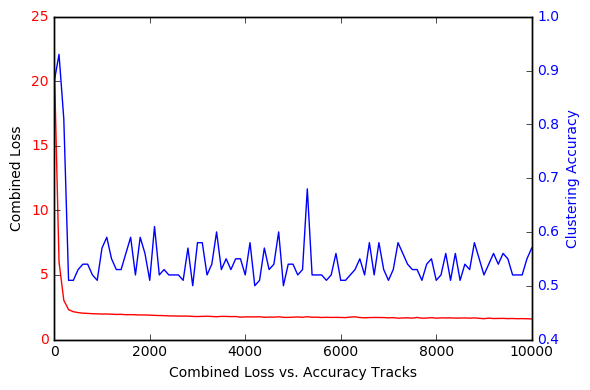

In [240]:
# 1st 100 epochs

plot_tracks()

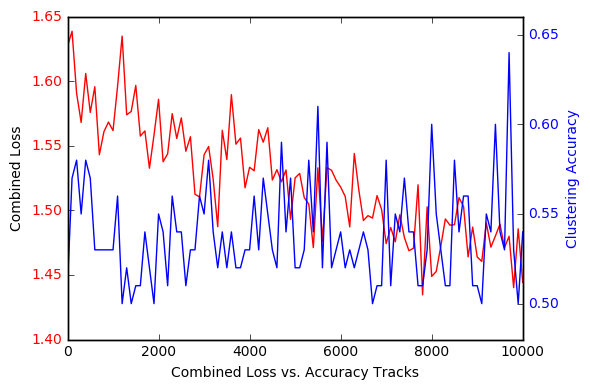

In [242]:
# 2nd 100 epochs

plot_tracks()

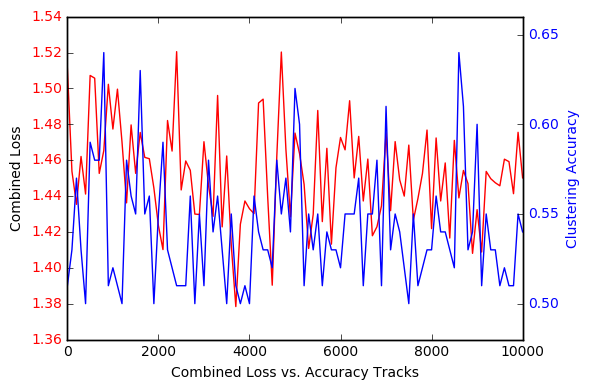

In [244]:
# 3rd 100 epochs

plot_tracks()

##### B. 5-10 sentence lengths

In [ ]:
# 1st 100 epochs

plot_tracks()

In [ ]:
# 2nd 100 epochs

plot_tracks()

In [ ]:
# 3rd 100 epochs

plot_tracks()